In [7]:
import cv2
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Paths
image_dir = '/workspace/data/Flicker8k_Dataset'
caption_file = '/workspace/data/Flickr8k_text/Flickr8k.token.txt'

# Read captions
captions_dict = defaultdict(list)
with open(caption_file, 'r') as f:
    for line in f:
        img_id, caption = line.strip().split('\t')
        img_file = img_id.split('#')[0]
        captions_dict[img_file].append(caption)

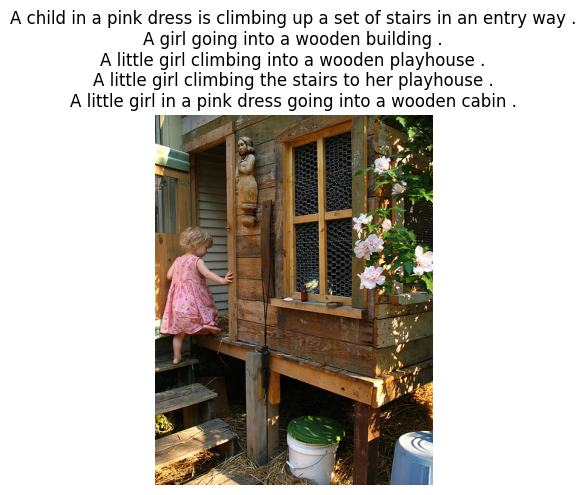

In [9]:
# Example image
img_filename = '1000268201_693b08cb0e.jpg'
img_path = os.path.join(image_dir, img_filename)

# Load with OpenCV (BGR format)
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Show using matplotlib
plt.imshow(image_rgb)
plt.axis('off')
plt.title("\n".join(captions_dict[img_filename]))
plt.show()


In [10]:
def preprocess_image_cv2(image_path, size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)
    image = image / 255.0  # Normalize to [0, 1]
    return image

In [11]:
# Create dataset (basic example, 1 caption per image)
image_data = []
text_data = []

for img_file, captions in list(captions_dict.items())[:1000]:  # use subset to fit in memory
    img_path = os.path.join(image_dir, img_file)
    img_array = preprocess_image_cv2(img_path)
    
    image_data.append(img_array)
    text_data.append(captions[0])  # Use the first caption

# Convert to NumPy arrays or PyTorch tensors as needed
image_data = np.array(image_data)

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from transformers import DistilBertTokenizer, DistilBertModel

import cv2
import os
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader


/usr/local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # scales to [0,1]
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

def load_image_cv2(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return transform(image)


In [14]:
class FlickrDataset(Dataset):
    def __init__(self, image_dir, captions_dict, tokenizer, max_len=32):
        self.image_dir = image_dir
        self.data = list(captions_dict.items())
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_file, captions = self.data[idx]
        img_path = os.path.join(self.image_dir, img_file)
        caption = captions[0]  # just one caption per image

        image = load_image_cv2(img_path)
        encoding = self.tokenizer(caption, return_tensors='pt',
                                  padding='max_length', truncation=True,
                                  max_length=self.max_len)
        return {
            'image': image,
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }


In [15]:
class DualEncoderModel(nn.Module):
    def __init__(self, img_embed_dim=256, text_embed_dim=256):
        super().__init__()
        # Image encoder (ResNet18 backbone)
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.img_encoder = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer
        self.img_fc = nn.Linear(512, img_embed_dim)

        # Text encoder (DistilBERT)
        self.text_encoder = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.text_fc = nn.Linear(768, text_embed_dim)

    def forward(self, image, input_ids, attention_mask):
        # Image encoding
        img_feat = self.img_encoder(image).squeeze(-1).squeeze(-1)
        img_embed = self.img_fc(img_feat)

        # Text encoding
        output = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_feat = output.last_hidden_state[:, 0, :]  # [CLS] token
        text_embed = self.text_fc(text_feat)

        # Normalize
        img_embed = nn.functional.normalize(img_embed, dim=-1)
        text_embed = nn.functional.normalize(text_embed, dim=-1)

        return img_embed, text_embed


In [16]:
def cosine_contrastive_loss(img_embeds, text_embeds, temperature=0.1):
    logits = torch.matmul(img_embeds, text_embeds.T) / temperature
    labels = torch.arange(len(logits)).to(logits.device)
    loss_i2t = nn.functional.cross_entropy(logits, labels)
    loss_t2i = nn.functional.cross_entropy(logits.T, labels)
    return (loss_i2t + loss_t2i) / 2


In [17]:
def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader):
        image = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        img_embeds, text_embeds = model(image, input_ids, attention_mask)
        loss = cosine_contrastive_loss(img_embeds, text_embeds)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)


In [19]:
# Load captions
from collections import defaultdict

image_dir = '/workspace/data/Flicker8k_Dataset'
caption_file = '/workspace/data/Flickr8k_text/Flickr8k.token.txt'

captions_dict = defaultdict(list)
with open(caption_file, 'r') as f:
    for line in f:
        img_id, caption = line.strip().split('\t')
        img_file = img_id.split('#')[0]
        captions_dict[img_file].append(caption)

# Use small subset for laptop training
subset_dict = dict(list(captions_dict.items())[:1000])

# Prepare dataset and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
dataset = FlickrDataset(image_dir, subset_dict, tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DualEncoderModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train
for epoch in range(5):
    loss = train(model, dataloader, optimizer, device)
    print(f"Epoch {epoch+1} Loss: {loss:.4f}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:27<00:00, 1.69MB/s]
100%|██████████| 63/63 [03:19<00:00,  3.16s/it]


Epoch 1 Loss: 1.9709


100%|██████████| 63/63 [02:43<00:00,  2.60s/it]


Epoch 2 Loss: 0.7981


100%|██████████| 63/63 [02:33<00:00,  2.43s/it]


Epoch 3 Loss: 0.3276


100%|██████████| 63/63 [03:05<00:00,  2.95s/it]


Epoch 4 Loss: 0.2058


100%|██████████| 63/63 [02:46<00:00,  2.64s/it]

Epoch 5 Loss: 0.1314
